In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE
import numpy as np
#import jplus
import class_tools as tools 


Using TensorFlow backend.
/Users/aaorsi/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


In [2]:
#load databases

#DataDir = './data/'
DataDir = '.'
import pickle
dset = pickle.load(open('%s/training_full.data'%DataDir))
print dset.keys()
ngal = len(dset['class'])
print ngal
dset_original = dset.copy() # keeping a copy of original datapoints for 


['rSDSS', 'iSDSS', 'obj', 'gSDSS', 'J0395', 'zSDSS', 'J0378', 'J0430', 'uSDSS', 'dm_j0660', 'J0660', 'J0410', 'J0515', 'J0861', 'class']
751


First of all, I split the full dataset into training and validation.

In [3]:
test, train = tools.split_trainset(dset, binary_class = 'OII') #20% in test, by default
ngal = len(train['class'])
print ngal

['OII', 'All']
601


** Here I add the option to resample all datasets sampling from their photometric errors. Each new sample has attribute $m$ drawn from a Gaussian with $\mu = m$ and $\sigma = \delta_m$, where $\delta_m$ is the photometric error of the attribute $m$.

In [4]:
train_rs = tools.resample_errors(train, nr=2500,verbose=True,balance_set=True)

Class Halpha range of rSDSS
18.334 - 20.477
Class OII range of rSDSS
20.809 - 22.082
Class OIII+Hbeta range of rSDSS
20.034 - 21.359
Class contaminant range of rSDSS
17.258 - 21.691


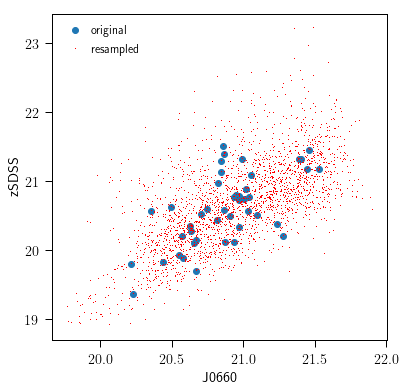

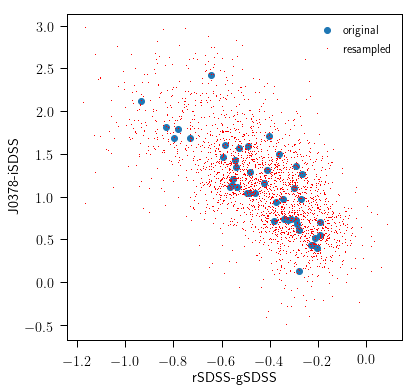

In [5]:
%matplotlib inline
# test if the above resampling was done correctly

import matplotlib.pyplot as plt

icl = 'OII'

sel1 = train['class'] == icl
sel2 = train_rs['class'] == icl

plt.figure(1,figsize=(6,6))
plt.plot(train['J0660'][sel1,0], train['zSDSS'][sel1,0],'o',label='original')
plt.plot(train_rs['J0660'][sel2,0], 
         train_rs['zSDSS'][sel2,0],',',color='red',label='resampled')
plt.xlabel('J0660')
plt.ylabel('zSDSS')

plt.legend()

plt.figure(2,figsize=(6,6))
plt.plot(train['rSDSS'][sel1,0] - train['gSDSS'][sel1,0], 
         train['J0378'][sel1,0] - train['iSDSS'][sel1,0],'o',label='original')

plt.plot(train_rs['rSDSS'][sel2,0] - train_rs['gSDSS'][sel2,0], 
         train_rs['J0378'][sel2,0] - train_rs['iSDSS'][sel2,0],',',color='red',label='resampled')
plt.xlabel('rSDSS-gSDSS')
plt.ylabel('J0378-iSDSS')

plt.legend()







In [6]:
from collections import Counter
print 'resampled set'
print(sorted(Counter(train_rs['class']).items()))
print 'original training set'
print(sorted(Counter(train['class']).items()))



resampled set
[('Halpha', 2500), ('OII', 2464), ('OIII+Hbeta', 2493), ('contaminant', 2152)]
original training set
[('Halpha', 10), ('OII', 44), ('OIII+Hbeta', 9), ('contaminant', 538)]


Below I construct features from each magnitude and all colour combinations. Then, the class variable is converted to an integer. Finally, A feature importances test is run using `extra_trees` to later select a subsample of important featuers

All colours: 66
All colours: 66
Feature ranking:
1. feature 76 (0.059363): $rSDSS - iSDSS$
2. feature 10 (0.059177): $rSDSS$
3. feature 6 (0.058899): $J0660$
4. feature 9 (0.046660): $gSDSS$
5. feature 74 (0.043545): $gSDSS - iSDSS$
6. feature 62 (0.041685): $J0660 - iSDSS$
7. feature 5 (0.040441): $J0515$
8. feature 4 (0.028968): $J0430$
9. feature 56 (0.027032): $J0515 - iSDSS$
10. feature 2 (0.023332): $J0395$
11. feature 3 (0.021069): $J0410$
12. feature 69 (0.020652): $uSDSS - gSDSS$
13. feature 7 (0.019639): $J0861$
14. feature 70 (0.018157): $uSDSS - rSDSS$
15. feature 59 (0.016729): $J0660 - uSDSS$
16. feature 49 (0.016102): $J0430 - iSDSS$
17. feature 53 (0.016065): $J0515 - uSDSS$
18. feature 77 (0.015971): $rSDSS - zSDSS$
19. feature 58 (0.015636): $J0660 - J0861$
20. feature 1 (0.015485): $J0378$
21. feature 11 (0.015106): $iSDSS$
22. feature 66 (0.015011): $J0861 - rSDSS$
23. feature 12 (0.013176): $zSDSS$
24. feature 63 (0.012875): $J0660 - zSDSS$
25. feature 8 (0.011710)

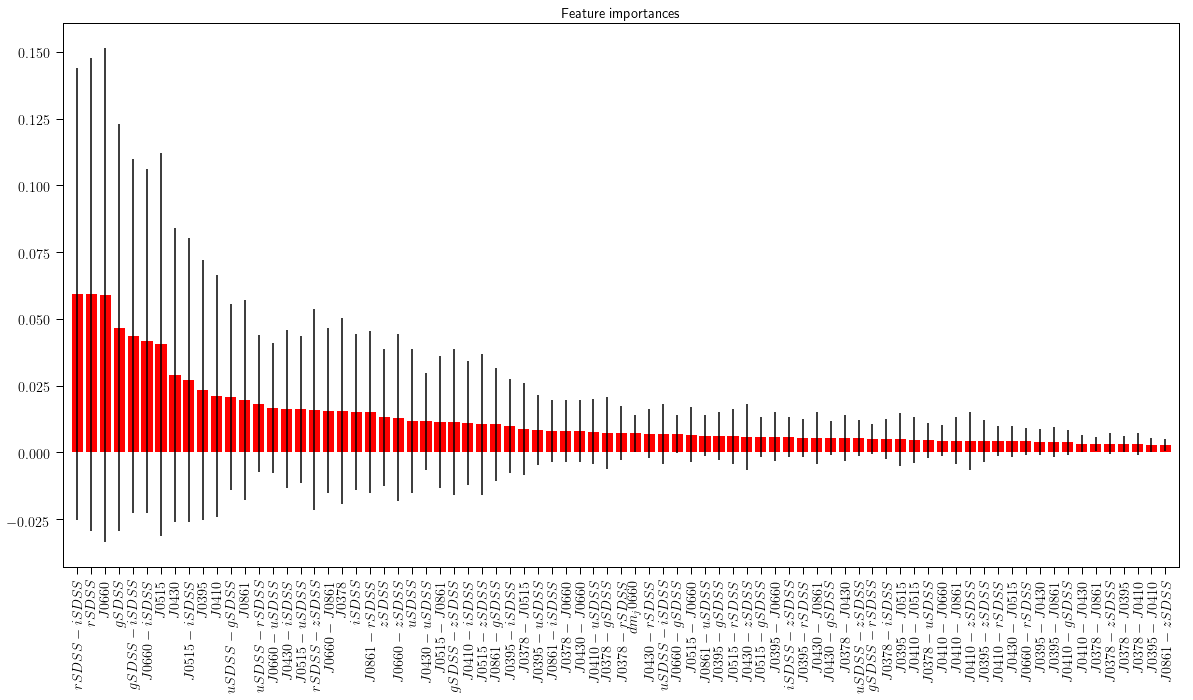

In [78]:
feat_arr, err_arr, featnames = tools.get_features(train_rs)
feat_arr_test, err_arr_test, featnames_test = tools.get_features(test)

y_train = [tools.class_to_int_binary(x,'OII') for x in train_rs['class']]
y_test = [tools.class_to_int_binary(x,'OII') for x in test['class']]

index, importance, inames = tools.feature_importance(feat_arr, y_train, featnames)



In [79]:
# Only keep the most important features

nfeat = 20

feats_id = index[0:nfeat]
print feats_id
print np.array(inames)[0:nfeat]

x_train = [np.array(x)[feats_id] for x in feat_arr]
x_test = [np.array(x)[feats_id] for x in feat_arr_test]


[76 10  6  9 74 62  5  4 56  2  3 69  7 70 59 49 53 77 58  1]
['$rSDSS - iSDSS$' '$rSDSS$' '$J0660$' '$gSDSS$' '$gSDSS - iSDSS$'
 '$J0660 - iSDSS$' '$J0515$' '$J0430$' '$J0515 - iSDSS$' '$J0395$'
 '$J0410$' '$uSDSS - gSDSS$' '$J0861$' '$uSDSS - rSDSS$' '$J0660 - uSDSS$'
 '$J0430 - iSDSS$' '$J0515 - uSDSS$' '$rSDSS - zSDSS$' '$J0660 - J0861$'
 '$J0378$']


In [80]:
#Get classess into one-hot vectors.


y_train_cat = keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_cat = keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))


nfeat = len(x_train[0])
print nfeat



20


***Before resampling, I'll look at the Feature Importances from Extra Trees***

The following is adapted from Sklearn's example of Feature Importances in

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


In [10]:
Balance_with_Smote = False

if Balance_with_Smote:
    from imblearn.over_sampling import SMOTE
    from collections import Counter
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train_int, test_size=0.2, random_state=1324)


    X_res, y_res = SMOTE(sampling_strategy='not majority').fit_resample(X_train, y_train)
    print(sorted(Counter(y_res).items()))

    y =  keras.utils.to_categorical(y_res, num_classes=len(np.unique(y_res)))
    yt = keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))

    print y[0]

Scale data using scikit-learn StandardScaler

In [81]:
from sklearn.preprocessing import StandardScaler 
Scaledata = True

if Scaledata:
    print 'scaling data...',
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_sc = scaler.transform(x_train)
    x_test_sc = scaler.transform(x_test)
    #x_test  = scaler.transform(x_test)
    print 'done'


scaling data... done


In [84]:
# Keras MLP

from keras import metrics

model = Sequential()
model.add(Dense(nfeat, activation='relu', input_dim=nfeat))
model.add(Dropout(0.3))
model.add(Dense(nfeat/2, activation='relu', input_dim=nfeat))
model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_24 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 22        
Total params: 652
Trainable params: 652
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.fit(x_train_sc, y_train_cat,
          shuffle=True,
          verbose=1,
          epochs=30,
          batch_size=200,
          validation_data=(x_test_sc, y_test_cat)
          )



Train on 9609 samples, validate on 150 samples
Epoch 1/30
9609/9609 [==============================] - 3s 337us/step - loss: 0.4838 - val_loss: 0.5054
Epoch 2/30
9609/9609 [==============================] - 0s 36us/step - loss: 0.3007 - val_loss: 0.4326
Epoch 3/30
9609/9609 [==============================] - 0s 35us/step - loss: 0.2284 - val_loss: 0.3899
Epoch 4/30
9609/9609 [==============================] - 0s 34us/step - loss: 0.1859 - val_loss: 0.3600
Epoch 5/30
9609/9609 [==============================] - 0s 37us/step - loss: 0.1641 - val_loss: 0.3291
Epoch 6/30
9609/9609 [==============================] - 0s 36us/step - loss: 0.1481 - val_loss: 0.3175
Epoch 7/30
9609/9609 [==============================] - 0s 38us/step - loss: 0.1430 - val_loss: 0.2962
Epoch 8/30
9609/9609 [==============================] - 0s 38us/step - loss: 0.1330 - val_loss: 0.2973
Epoch 9/30
9609/9609 [==============================] - 0s 52us/step - loss: 0.1274 - val_loss: 0.2859
Epoch 10/30
9609/9609 [==

In [86]:
from sklearn.metrics import f1_score

pred_tr = model.predict(x_train_sc)
pred_train = [np.argmax(x) for x in pred_tr]
y_new_train = [np.argmax(x) for x in y_train_cat]

pred_te = model.predict(x_test_sc)
pred_test = [np.argmax(x) for x in pred_te]
y_new_test = [np.argmax(x) for x in y_test_cat]


score_train = f1_score(y_new_train, pred_train,average=None)
score_test = f1_score(y_new_test, pred_test,average=None)

print 'f1_scores on training set'
print score_train
print 'f1_scores on test set'
print score_test





f1_scores on training set
[0.98159423 0.94664232]
f1_scores on test set
[0.94296578 0.59459459]


**Here I try GridSearchCV**

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers

def build_classifier(optim='sgd',drop=0.0,Neurons=nfeat,init='uniform'):
   #   from keras.optimizers import SGD
    model = Sequential()
    model.add(Dense(Neurons, input_dim=nfeat, kernel_initializer=init, activation='sigmoid'))
    model.add(Dropout(drop))
    model.add(Dense(Neurons/2, activation='sigmoid'))
#    model.add(Dropout(drop))
    model.add(Dense(4, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim)
    return model

seed = 7132
np.random.seed(seed)

model = KerasClassifier(build_fn=build_classifier, verbose=0)

optim = ['sgd','adam']#,'rmsprop','sgd'] #['rmsprop', 'adam']
init = ['uniform']#['glorot_uniform', 'normal', 'uniform']
epochs = [10, 20]
batches = [50,100]#,200,500]#,500]#, 500]
dropout = [.1]#1e-3,1e-2,1e-1]#,0.5,0.75]
Neurons = [nfeat/2]
param_grid = dict(optim=optim, epochs=epochs, batch_size=batches, init=init,drop=dropout,
                 Neurons=Neurons)



In [ ]:
print y[0]

In [ ]:
from sklearn.metrics import make_scorer, fbeta_score,f1_score

# pos_label below optimises the f score for a particular label
f2_score = make_scorer(fbeta_score, beta=1,average='macro')
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring=f2_score,verbose=10,n_jobs=4)
grid_result = grid.fit(x_train, y_res)

best= grid_result.best_estimator_

In [ ]:
y_pred = best.predict(x_train, verbose=1)

score = f1_score(y_res,y_pred,average=None, labels=range(4))
print score
pred_names = [int_to_class(x) for x in range(4)]
print pred_names

y_pt = best.predict(x_test, verbose=1)

score = f1_score(y_new_num,y_pt,average=None, labels=range(4))
print score
pred_names = [int_to_class(x) for x in range(4)]
print pred_names




In [ ]:
df = grid_result.cv_results_
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


